<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Ex/Ex7/2_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài toán phân loại sử dụng SVM


Mục tiêu:

- Xây dựng được mô hình svm sử dụng thư viện sklearn.
- Ứng dụng, hiểu cách áp dụng mô hình svm vào giải quyết bài toán thực tế (vd: phân loại tin tức dạng văn bản) .
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình.

Vấn đề:

- Có một tập các văn bản dạng text không có nhãn, làm sao để biết văn bản này là thuộc về thể loại nào, pháp luật, đời sống, văn học, thể thao ...
- Cần xây dựng mô hình học máy phân loại các thể loại của văn bản dựa trên nội dung.  

Dữ liệu:

- Có tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian
- Tập các nhãn - 10 nhãn văn bản:
    > Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội
- Ví dụ văn bản nhãn **thể thao**:
    > "Dân_trí Real Madrid đã dẫn trước trong cả trận đấu , nhưng họ vẫn phải chấp_nhận bị Dortmund cầm hòa 2-2 ở Bernabeu . Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ..."

Bài toán:

- Input: tập các từ trong văn bản 1 mẫu dữ liệu $X = [x_1, x_2, ... x_n]$
- Output: nhãn $y$ là 1 trong 10 nhãn trên

In [56]:
# Cài đặt thư viện xử lý ngôn ngữ cho tiếng Việt!
!pip install pyvi

In [57]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

## 1. Sử dụng sklearn.datasets.load_files để load dữ liệu từ thư mục đã down từ trước

Cấu trúc thư mục như sau

- data/news_1135/

    - Kinh tế:
        - bài báo 1.txt
        - bài báo 2.txt
    - Pháp luật
        - bài báo 3.txt
        - bài báo 4.txt

In [58]:
data_train = load_files(container_path="data/news_1135/", encoding="utf-8")

print(data_train.filenames)
print()

print("Tong so file: {}" .format( len(data_train.filenames)))
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )


['data/news_1135/Kinh tế/c3926c2bf603cd4c4474f1e3e21159dc2c732c6d.txt'
 'data/news_1135/Độc giả/ce52a3d65605ca1b22a698ea45d345e70d251809.txt'
 'data/news_1135/Kinh tế/aeadfcd44b05f4adf6641e3f77398525837b333e.txt' ...
 'data/news_1135/Thời sự/a12673b7661ec06056b5e20ba7d4c83aebbf6334.txt'
 'data/news_1135/Sức khỏe/43b45beb5f82fa0dcfc228bd78d287a26a251026.txt'
 'data/news_1135/Thể thao/7c4e2c0d15cf600e6b60d4cd195d89ee0eb3e408.txt']

Tong so file: 1134
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin khác'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


###  Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận

In [59]:
# load dữ liệu các stopwords
with open("data/vietnamese-stopwords.txt",encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])

# Transforming data
# Chuyển hoá dữ liệu text về dạng vector tfidf
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6928)
2 :  ('sát', 17612)
3 :  ('tết_nguyên_đán', 20830)
4 :  ('nhu_cầu', 14012)
5 :  ('trang_trí', 19570)
6 :  ('nhà_cửa', 14035)
7 :  ('đón', 23409)
8 :  ('tết', 20829)
9 :  ('đại_gia', 23617)
10 :  ('tiếc', 19301)
11 :  ('tiền', 19370)


### Bài 1: Sử dụng trực tiếp TfidfVectorizer()
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [60]:
# Chú ý: có thể biến đổi dữ liệu về dạng Tf-Idf trực tiếp sử dụng TfidfVectorizer()
# Bài tập:
# - thực hiện điều đó
# code
tfidf_vector = TfidfVectorizer(stop_words = stopwords)
data_tfidf = tfidf_vector.fit_transform(data_train.data, data_train.target)


# - hiển thị 10 từ trong văn bản đầu tiên có giá trị tfidf cao nhất
first_doc_vector = data_tfidf[0].toarray().flatten()
feature_names = np.array(tfidf_vector.get_feature_names_out())
sorted_tfidf = np.argsort(data_tfidf[0].toarray().flatten())[::-1]

print("\nTop 10 từ có giá trị TF-IDF cao nhất trong văn bản đầu tiên:")
for word, score in zip(feature_names[sorted_tfidf[:10]], first_doc_vector[sorted_tfidf[:10]]):
    print(f"{word}: {score:.2f}")


Top 10 từ có giá trị TF-IDF cao nhất trong văn bản đầu tiên:
công: 0.60
chim: 0.28
trang_trại: 0.27
quỳnh: 0.22
trứng: 0.20
ngũ_sắc: 0.17
mua: 0.16
đẹp: 0.14
nhân_giống: 0.12
huy: 0.11


### Chia dữ liệu làm 2 phần training và testing

- Training chiếm 80 % dữ liệu
- Testing chiếm 20 % dữ liệu

In [61]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data_preprocessed, data_train.target, test_size=test_size)

# hiển thị một số thông tin về dữ liệu
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )

Dữ liệu training:  (907, 24389) (907,)
Dữ liệu testing:  (227, 24389) (227,)
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin khác'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


## 2. Training svm model

Sử dụng thư viện sklearn để xây dựng mô hình
-  Thử trước với hàm nhân phân tách là Linear, tham số C=1.0
- `svm.SVC(kernel='linear', C=1.0)`


In [62]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)
print("- model - train complete")


- Training ...
- Train size = (907, 24389)
- model - train complete


## 3. Testing svm model

Thực hiện dự đoán nhãn cho từng văn bản trong tập test

Độ đo đánh giá:
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test  

In [63]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))


- Testing ...
- Test Acc = 0.8414096916299559
- Train Acc = 0.9933847850055126


### Bài 2: thực hiện lại các bước trên với kernel = 'rbf'

In [64]:
# code
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model_svm_rbf = svm.SVC(kernel='rbf', C=1)
model_svm_rbf.fit(X_train, y_train)
print("- model - train complete")

print("- Testing ...")
y_test_pred_rbf = model_svm_rbf.predict(X_test)
y_train_pred_rbf = model_svm_rbf.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred_rbf)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred_rbf)))


- Training ...
- Train size = (907, 24389)
- model - train complete
- Testing ...
- Test Acc = 0.7665198237885462
- Train Acc = 0.9955898566703418


### 3.1. Thực hiện sử dụng model đã được train để infer 1 văn bản mới
- Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
- infer sử dụng hàm model.predict(dữ_liệu_ma_trận)

In [65]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess.
new_doc = "Công phượng ghi bàn cho đội tuyển Việt nam"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Công phượng ghi_bàn cho đội_tuyển Việt_nam']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 24389)>
  Coords	Values
  (0, 5847)	0.3302100365610822
  (0, 7777)	0.46178440053088166
  (0, 15553)	0.6394566344207014
  (0, 21498)	0.23572628046602445
  (0, 24149)	0.46178440053088166


### Bài 3: dự đoán nhãn của văn bản trên

In [66]:
# code
label = model.predict(input_data_preprocessed)
print("Văn bản mới dự đoán nhãn là: ", label, data_train.target_names[label[0]])

Văn bản mới dự đoán nhãn là:  [2] Kinh tế


## 4. Bài tập bổ sung:

### 4.1 Thử nghiệm các tham số

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, gamma, kernel.
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất
- Gợi ý:
    - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Sử dụng grid search

#### Bài 4: Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

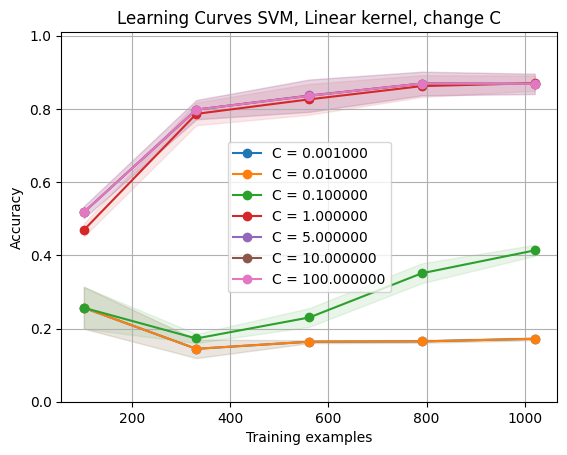

In [68]:
# code
# tham khảo miền của C
list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]

# hàm sinh id màu
def get_cmap(n):
    return 'C' + str(n)

# Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng matlibplot
def plot_learning_curve(estimator, title, label_curve, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5), new_plot = False,
                        idx_color = 0):

    # Khởi tạo bức ảnh mới với thư viện plot lib
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()

    # chú thích nếu có
    if ylim is not None:
        plt.ylim(*ylim)

    # thực hiện training model, ghi nhận các giá trị trong quá trình training
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")

    # Lấy trung bình cộng các giá trị output của các fold
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    # random 1 màu để vẽ
    color = get_cmap(idx_color)

    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = color)
    plt.plot(train_sizes, test_scores_mean, 'o-', color = color,
             label = label_curve)

    plt.legend(loc = "best")
    return plt

list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
# model title
title = "Learning Curves SVM, Linear kernel, change C"

# duyệt qua mảng các giá trị của tham số C
for i, C in enumerate(list_C):
    # Với từng giá trị C nhận được,
    # thực hiện build model và training cross-validate
    # vẽ kết quả tìm được lên đồ thị đường.
    text_clf = Pipeline([
                         ('clf', svm.SVC(kernel = 'linear', C = C)), # mô hình svm với tham số C
                         ])

    plt = plot_learning_curve(text_clf, title, "C = %f" % (C),
                              data_preprocessed, data_train.target,
                              (0.0, 1.01), cv = 10, n_jobs = -1, idx_color = i, new_plot = i == 0)
plt.show()

#### Bài 5: Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [53]:
# code
# Có thể tham khảo giá trị các tham số như sau
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.0001, 0.001, 0.01, 0.1],
'kernel':['linear','rbf', 'poly'] }
model = svm.SVC()
#Create the GridSearchCV object
best_model = GridSearchCV(model, params_grid, cv=4, n_jobs=-1, scoring = "accuracy")
#Fit the data with the best possible parameters
best_model.fit(X_train, y_train)
#Print the best estimator with it's parameters
print (best_model.best_params_)
print (best_model.best_estimator_)
# Test best_model
print('Testing')
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
SVC(C=10, gamma=0.0001, kernel='linear')
Testing
0.8678414096916299


### 4.2 Phân loại số viết tay

Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


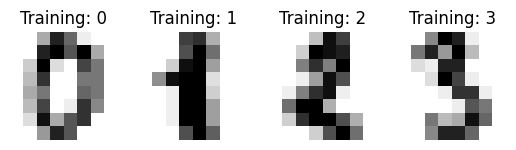

In [54]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()
from sklearn.svm import SVC
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)


#### Bài 6: phân loại với dữ liệu trên

In [55]:
##### exercise #####
# Yêu cầu: Ứng dụng mô hình svm vào bài toán phân loại ảnh
# Gợi ý: dữ liệu đã được chia train, test, Áp dụng phần 2. và 3. để training và testing model. Chú ý nên có thêm phần tuning model
######################

# model = None

######################
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1],}

grid_search = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1,
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 5.0, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV Accuracy: 0.9902534965034967
